In [5]:
import google.colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data_path = "/content/drive/MyDrive/chatbot/job_intents.json"

In [7]:
# Step 0: Environment + imports + Colab-safe drive mount
import os
import json
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD

In [8]:
# Colab-safe drive mount: attempt to mount if running on Colab, otherwise use cwd
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')
    data_base_path = '/content/drive/MyDrive/chatbot'
    print("Running on Colab. Using data_base_path =", data_base_path)
except Exception:
    data_base_path = os.getcwd()
    print("Not running on Colab. Using current working directory as data_base_path =", data_base_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running on Colab. Using data_base_path = /content/drive/MyDrive/chatbot


In [9]:
# Step 1: data path and NLTK downloads
data_path = os.path.join(data_base_path, 'job_intents.json')

if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data file not found at: {data_path}\nPlease place job_intents.json in {data_base_path}")

# NLTK resources (download if needed)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [10]:
# Step 2: load JSON intents
with open(data_path, 'r', encoding='utf-8') as f:
    intents = json.load(f)

In [11]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
# Step 3: preprocessing: tokenization, lemmatization, collect words/classes/documents
lemmatizer = WordNetLemmatizer()
ignore_words = ['?', '!', '.', ',']

words = []       # all unique words (raw tokens, will lemmatize later)
classes = []     # unique intent tags
documents = []   # list of (tokenized_pattern, tag) tuples

for intent in intents.get('intents', []):
    tag = intent.get('tag')
    for pattern in intent.get('patterns', []):
        tokens = word_tokenize(pattern)
        words.extend(tokens)
        documents.append((tokens, tag))
    if tag not in classes:
        classes.append(tag)

# Lemmatize and lower-case words, remove ignored tokens, deduplicate & sort
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(set(words))
classes = sorted(set(classes))

print("Total unique words:", len(words))
print("Total classes:", len(classes))
print("Total documents:", len(documents))


Total unique words: 157
Total classes: 102
Total documents: 313


In [13]:
# Step 4: create bag-of-words vector function and build training set
def bag_of_words(tokenized_sentence, all_words):
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in tokenized_sentence]
    bag = [1 if w in sentence_words else 0 for w in all_words]
    return np.array(bag, dtype=int)

training = []
output_empty = [0] * len(classes)

for doc in documents:
    pattern_tokens = doc[0]
    tag = doc[1]
    bag = bag_of_words(pattern_tokens, words)
    output_row = output_empty.copy()
    output_row[classes.index(tag)] = 1
    training.append([bag, output_row])


In [14]:
# Step 5: shuffle and split into train_x, train_y
random.shuffle(training)

# --- FIX: use list comprehensions to extract columns (works independent of numpy shape) ---
train_x = [t[0] for t in training]
train_y = [t[1] for t in training]

train_x = np.array(train_x, dtype=float)
train_y = np.array(train_y, dtype=float)

print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)

VALIDATION_SET = (train_x, train_y)


train_x shape: (313, 157)
train_y shape: (313, 102)


In [15]:
# Step 6: Create a simple feed-forward network
input_size = train_x.shape[1]
output_size = train_y.shape[1]

model = Sequential()
model.add(Dense(128, input_shape=(input_size,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(output_size, activation='softmax'))

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 102)            │         6,630 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,110 (137.15 KB)

 Trainable params: 35,110 (137.15 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Step 7: Compile the model
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [17]:
# Step 8: Train
history = model.fit(
    train_x,
    train_y,
    epochs=250,
    batch_size=5,
    validation_split=0.2,
    verbose=1
)


Epoch 1/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.0065 - loss: 4.6613 - val_accuracy: 0.0159 - val_loss: 4.6458
Epoch 2/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0339 - loss: 4.6098 - val_accuracy: 0.0317 - val_loss: 4.6484
Epoch 3/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0337 - loss: 4.5983 - val_accuracy: 0.0317 - val_loss: 4.6605
Epoch 4/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0474 - loss: 4.5704 - val_accuracy: 0.0317 - val_loss: 4.6707
Epoch 5/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0684 - loss: 4.5262 - val_accuracy: 0.0317 - val_loss: 4.6742
Epoch 6/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0770 - loss: 4.4890 - val_accuracy: 0.0317 - val_loss: 4.6767
Epoch 7/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0847 - loss: 4.4187 - val_accuracy: 0.0317 - val_loss: 4.6901
Epoch 8/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0930 - loss: 4.3336 - val_accuracy: 0.0476 - 

In [18]:
# Step 9: Save model + words/classes + training history
model.save('ds_chatbot_model.h5')
pickle.dump({
    'words': words,
    'classes': classes,
    'history': history.history
}, open('ds_chatbot_data.pkl', 'wb'))

print("Model saved to 'ds_chatbot_model.h5' and data saved to 'chatbot_data.pkl'")


Model saved to 'ds_chatbot_model.h5' and data saved to 'chatbot_data.pkl'


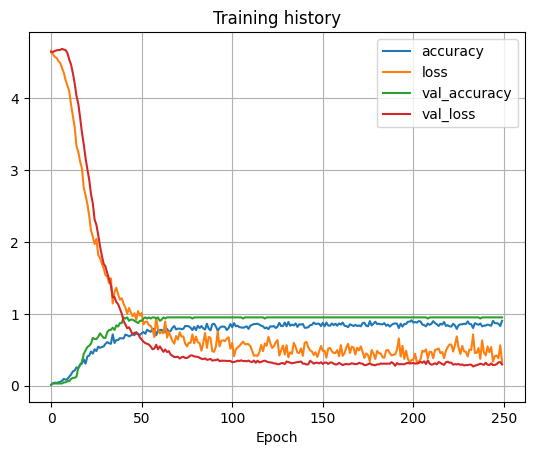

In [19]:
# Step 10: plot history (accuracy/loss)
pd.DataFrame(history.history).plot()
plt.title("Training history")
plt.xlabel("Epoch")
plt.grid(True)
plt.show()


In [20]:
import json
import pickle

# ---------------------------
# 1. Load job_intents.json
# ---------------------------
with open(data_path, "r", encoding="utf-8") as f:
    intents = json.load(f)

In [21]:
# ---------------------------
# 2. Extract unique classes (tags)
# ---------------------------
classes = []

for intent in intents.get("intents", []):
    tag = intent.get("tag")
    if tag and tag not in classes:
        classes.append(tag)

# Sort classes
classes = sorted(classes)

print("Total classes found:", len(classes))
print(classes)

Total classes found: 102
['a/b_testing', 'acf/pacf', 'anomaly_detection', 'anova', 'arima', 'attention_mechanism', 'automl', 'bag_of_words', 'bayesian_optimization', 'bayesian_statistics', 'bert', 'bias-variance_tradeoff', 'big_data_concepts', 'catboost', 'chi-square_test', 'clustering', 'convolutional_neural_networks', 'correlation_analysis', 'cross-validation', 'dashboards', 'data_pipelines', 'data_visualization', 'data_warehousing', 'dbscan', 'decision_trees', 'deep_learning', 'deep_q_networks', 'docker_for_ml', 'elastic_net', 'ensemble_methods', 'etl_processes', 'ets_models', 'experiment_tracking', 'fastapi_for_ml', 'feature_engineering', 'feature_selection', 'flask_for_ml', 'glove', 'gpt_models', 'gradient_boosting', 'greeting', 'grid_search', 'grus', 'hadoop', 'hierarchical_clustering', 'hyperparameter_tuning', 'hypothesis_testing', 'k-means', 'k-nearest_neighbors', 'l1_regularization', 'l2_regularization', 'lightgbm', 'lime', 'linear_regression', 'logistic_regression', 'lstms', 

In [22]:
# ---------------------------
# 3. Save classes.pkl
# ---------------------------
with open("classes.pkl", "wb") as f:
    pickle.dump(classes, f)

print("\nclasses.pkl file successfully created!")


classes.pkl file successfully created!


In [23]:
import json
import pickle
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required NLTK models (first time only)
nltk.download('punkt')
nltk.download('wordnet')

# --------------------------------------
# 1. Load job_intents.json
# --------------------------------------
with open(data_path, "r", encoding="utf-8") as f:
    intents = json.load(f)

# --------------------------------------
# 2. Preprocessing setup
# --------------------------------------
lemmatizer = WordNetLemmatizer()
ignore_words = ['?', '!', '.', ',']

words = []        # vocabulary list
documents = []    # (pattern, tag) pairs

# --------------------------------------
# 3. Tokenize, lemmatize & collect words
# --------------------------------------
for intent in intents["intents"]:
    for pattern in intent["patterns"]:
        tokens = word_tokenize(pattern)               # tokenize
        words.extend(tokens)                          # add tokens
        documents.append((tokens, intent["tag"]))     # store structure

# --------------------------------------
# 4. Clean words → lower, lemmatize, remove symbols
# --------------------------------------
words = [lemmatizer.lemmatize(w.lower())
         for w in words
         if w not in ignore_words]

# unique + sorted
words = sorted(list(set(words)))

print("Total unique words:", len(words))
print(words[:50])   # first 50 words preview

# --------------------------------------
# 5. Save words.pkl
# --------------------------------------
with open("words.pkl", "wb") as f:
    pickle.dump(words, f)

print("\nwords.pkl successfully created!")


Total unique words: 157
['a/b', 'about', 'acf/pacf', 'analysis', 'anomaly', 'anova', 'anyone', 'are', 'arima', 'attention', 'automl', 'bag', 'basic', 'bayes', 'bayesian', 'bert', 'bi', 'bias-variance', 'big', 'boosting', 'catboost', 'chi-square', 'clustering', 'concept', 'convolutional', 'correlation', 'cross-validation', 'dashboard', 'data', 'day', 'dbscan', 'decision', 'deep', 'deployment', 'detection', 'distribution', 'docker', 'drift', 'ekse', 'elastic', 'embeddings', 'engineering', 'ensemble', 'etl', 'ets', 'experiment', 'explain', 'explainability', 'fastapi', 'feature']

words.pkl successfully created!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
